In [1]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pwd
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download m5-forecasting-accuracy

! unzip /content/m5-forecasting-accuracy.zip > /dev/null

-rw-r--r-- 1 root root 74 Sep  6 17:13 kaggle.json
/content
 81% 37.0M/45.8M [00:00<00:00, 101MB/s]
100% 45.8M/45.8M [00:00<00:00, 109MB/s]


In [24]:
import plotly.graph_objs as go
import matplotlib.pylab as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import random


warnings.filterwarnings("ignore")
seed = 101
random.seed(seed)
np.random.seed(seed)

# Read data

calendar.csv - Contains information about the dates on which the products are sold.

sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]

sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.

sell_prices.csv - Contains information about the price of the products sold per store and date.

In [ ]:
def reduce_mem(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [3]:
t_val = pd.read_csv('/content/sales_train_validation.csv')
print('Validation memory usage: ', t_val.memory_usage().sum())

# t_eval = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
# t_eval = reduce_mem(t_eval)

prices = pd.read_csv('/content/sell_prices.csv')
print('Prices memory usage: ', prices.memory_usage().sum())
# prices = reduce_mem(prices)
# print('Prices memory usage after downcasting: ', prices.memory_usage().sum())

calendar = pd.read_csv('/content/calendar.csv')
print('Calendar memory usage: ', calendar.memory_usage().sum())
# calendar = reduce_mem(calendar)
# print('Calendar memory usage after downcasting: ', calendar.memory_usage().sum())

Validation memory usage:  468082608
Prices memory usage:  218916000
Calendar memory usage:  220656


In [4]:
calendar.replace(np.nan, 'No_event', inplace=True)

In [5]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [6]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,No_event,No_event,No_event,No_event,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,No_event,No_event,No_event,No_event,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,No_event,No_event,No_event,No_event,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,No_event,No_event,No_event,No_event,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,No_event,No_event,No_event,No_event,1,0,1


In [7]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  1969 non-null   object
 8   event_type_1  1969 non-null   object
 9   event_name_2  1969 non-null   object
 10  event_type_2  1969 non-null   object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [8]:
t_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [9]:
print('States:',len(t_val['state_id'].unique()))
print('Stores:',len(t_val['store_id'].unique()))
print('Items:',len(t_val['item_id'].unique()))
print('Categories:',len(t_val['cat_id'].unique()))
print('Departments:',len(t_val['dept_id'].unique()))

States: 3
Stores: 10
Items: 3049
Categories: 3
Departments: 7


## Total sales across the three states

In [13]:
days = [i for i in t_val.columns.values if 'd_' in i]
date = calendar.loc[:1912,'date']

years_sales_df = pd.DataFrame({'Years':date, "Sales":t_val[days].sum(axis=0).values})

fig = px.line(data_frame=years_sales_df, x="Years", y="Sales")
fig.show()

## The best-selling product and state

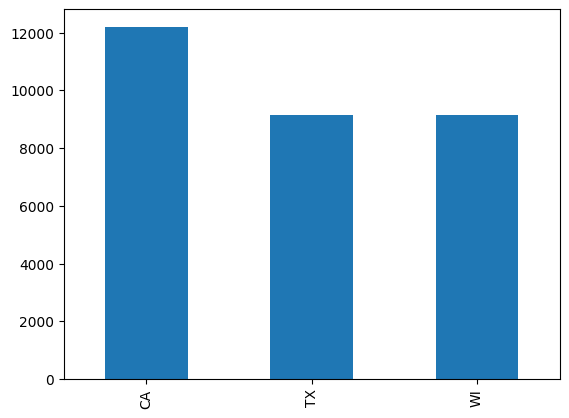

In [11]:
t_val['state_id'].value_counts().plot(kind='bar');

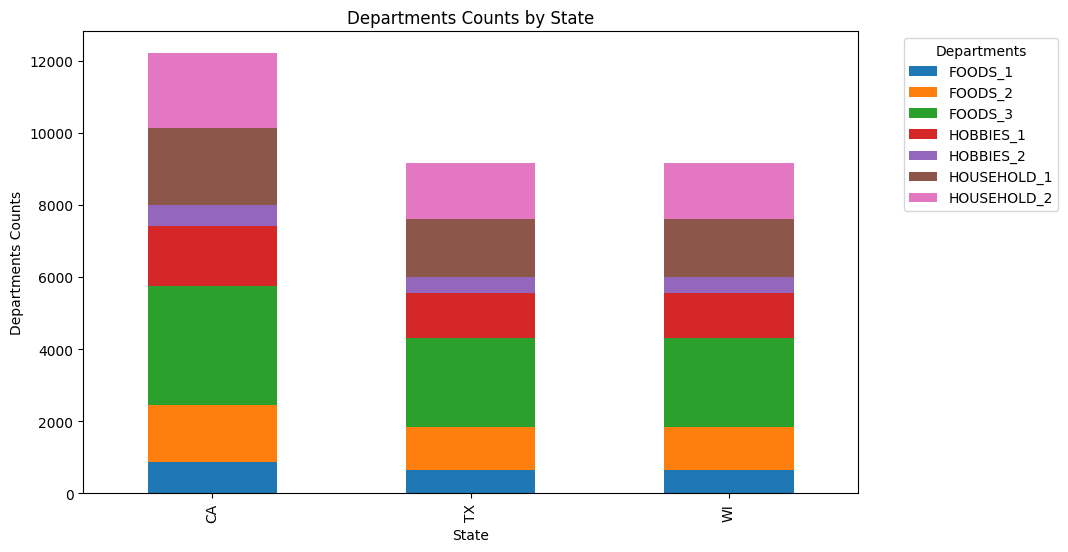

In [12]:
cat_counts_by_state = t_val.groupby(['state_id', 'dept_id']).size().unstack(fill_value=0)
cat_counts_by_state.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('State')
plt.ylabel('Departments Counts')
plt.title('Departments Counts by State')
plt.legend(title='Departments', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

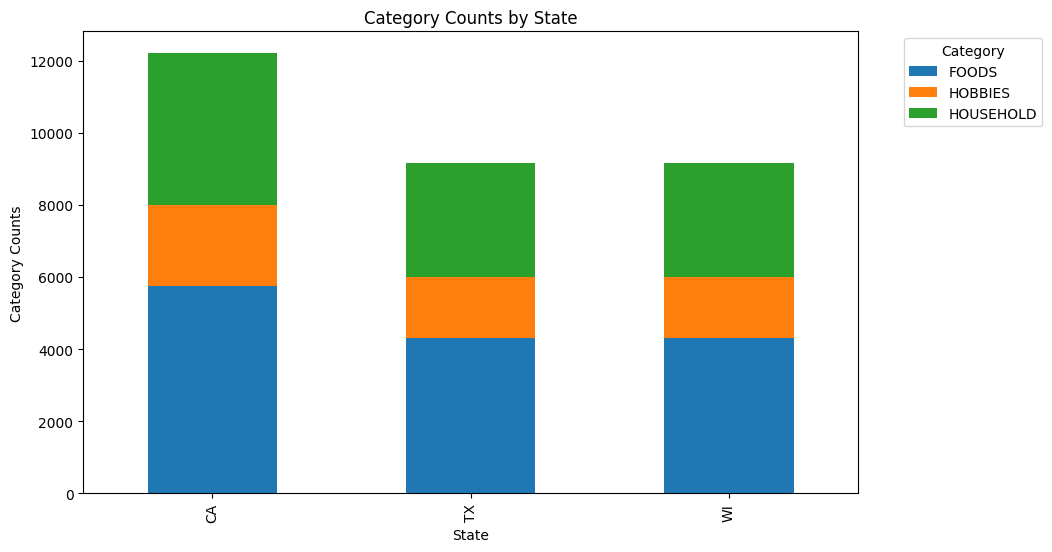

In [14]:
cat_counts_by_state = t_val.groupby(['state_id', 'cat_id']).size().unstack(fill_value=0)
cat_counts_by_state.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('State')
plt.ylabel('Category Counts')
plt.title('Category Counts by State')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

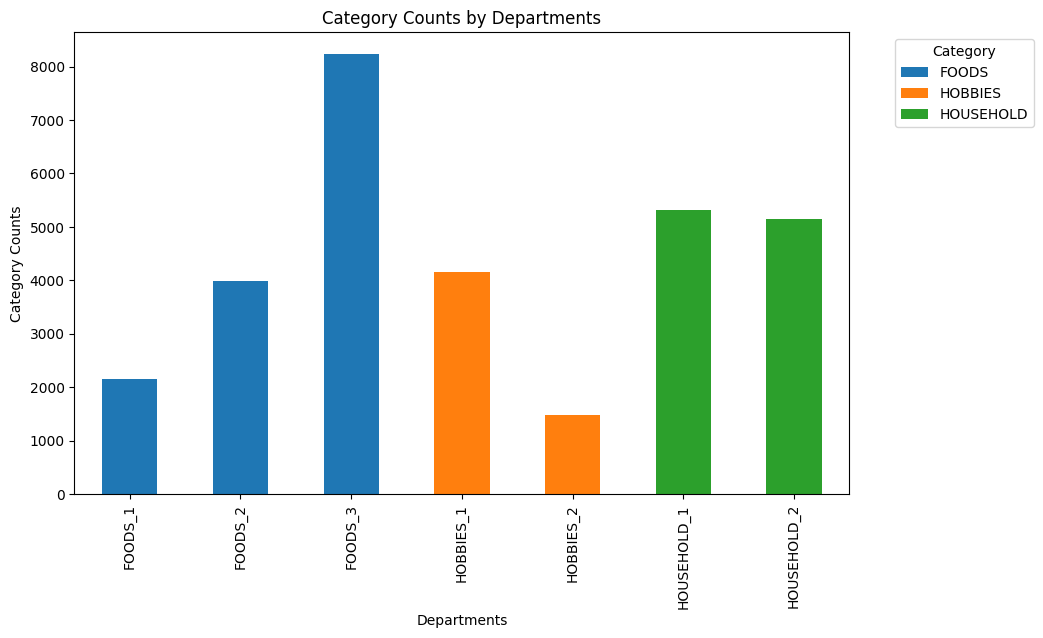

In [15]:
cat_counts_by_state = t_val.groupby(['dept_id', 'cat_id']).size().unstack(fill_value=0)
cat_counts_by_state.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Departments')
plt.ylabel('Category Counts')
plt.title('Category Counts by Departments')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

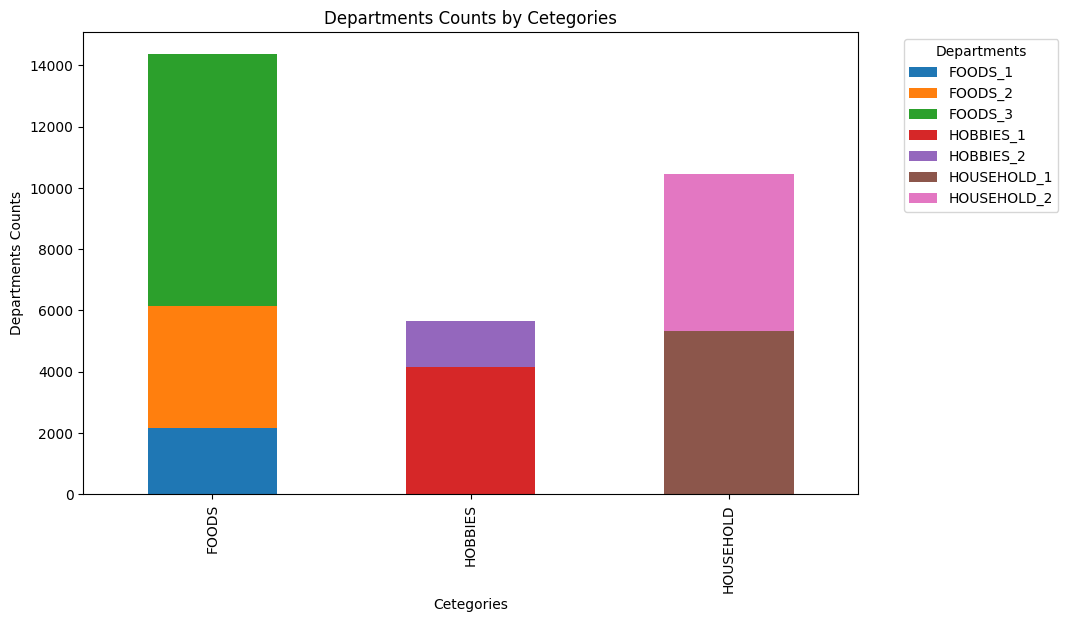

In [16]:
cat_counts_by_state = t_val.groupby(['cat_id', 'dept_id']).size().unstack(fill_value=0)
cat_counts_by_state.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Cetegories')
plt.ylabel('Departments Counts')
plt.title('Departments Counts by Cetegories')
plt.legend(title='Departments', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [25]:
temp_df = t_val.groupby('state_id').sum().T
temp_df.columns = temp_df.columns.astype(str)

dates = ["".join(str(i).split('-')[:2]) for i in date]
temp_df['Date'] = dates
temp_df = temp_df.groupby("Date").sum()

In [18]:
temp_df.head()

state_id,CA,TX,WI
Date,,,
201101,38108,25846,24209
201102,318101,212015,196259
201103,339678,225162,198727
201104,331004,220681,186028
201105,321566,221620,176376


## Let's find more interesting things!

In [21]:
def group_plot(category, title, x, y, from_=0, to=None):

    temp_df = t_val.groupby(category).sum().T
    temp_df.columns = temp_df.columns.astype(str)

    dates = ["".join(str(i).split('-')[:2]) for i in date]
    temp_df['Date'] = dates
    temp_df = temp_df.groupby("Date").sum()

    list_of_dates = pd.date_range(start='2011-01-01', end='2016-04-01', freq='MS')

    scatters = []
    for i, column in enumerate(temp_df.columns[from_:to], start=from_):
        scatter = go.Scatter(x=list_of_dates, y=temp_df[column], mode='lines', name=str(column).title())
        scatters.append(scatter)

    layout = go.Layout(
        title=title,
        title_x=0.5,
        xaxis_title=x,
        yaxis_title=y,
        width=1000
    )

    fig = go.Figure(data=scatters, layout=layout)
    fig.show()

In [26]:
group_plot(category='dept_id', title='Sales for each department of products', x='Year', y='Sales')

In [27]:
group_plot(category='state_id', title='Sales for each state', x='Year', y='Sales')

In [28]:
group_plot(category='store_id', title='Sales of each store in all states', x='Year', y='Sales')

In [29]:
t_val_melt = pd.melt(t_val, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='demand')

CA_3_sales = t_val_melt[t_val_melt.store_id == "CA_3"]
CA_3 = pd.merge(CA_3_sales, calendar, left_on="day", right_on="d", how="left")
CA_3 = pd.merge(CA_3, prices, left_on=["store_id", "item_id", "wm_yr_wk"],right_on=["store_id", "item_id", "wm_yr_wk"], how="left")
CA_3["day_index"] = CA_3.day.apply(lambda x: int(x.split("_")[-1]))

In [30]:
item_id = CA_3.groupby("item_id")[["sell_price", "demand"]].agg({
                        "sell_price": ["mean"],
                        "demand" : ["mean"]}).reset_index()

In [31]:
sum_prices = CA_3.groupby("day_index")[["sell_price", "demand"]].agg("sum").reset_index()
trace = go.Scatter(x=sum_prices.day_index,
                         y=sum_prices.sell_price,
                         mode="lines",
                         name="sell_price",
                         )

fig = go.Figure(data=trace)
fig.show()

In [32]:
events = CA_3[~CA_3.event_name_1.isna()]
events = events.groupby("event_name_1")[["demand", "sell_price"]].agg(["mean", "max"]).reset_index()
events.columns = ['_'.join(col).strip() for col in events.columns.values]

In [34]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=events["event_name_1_"],
                         y=events["demand_mean"],
                         mode="lines",
                         name="week_day"
))

fig.update_layout(height=500, title_text="Demand in different holidays")
fig.show()